In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import sys
import networkx as nx
import plotly.graph_objs as go
from plotly.offline import plot
import time
import igraph as ig
import math


In [9]:

def get_polygon_centroid(vertex_coords):
    x_coords = [coord[0] for coord in vertex_coords]
    y_coords = [coord[1] for coord in vertex_coords]
    centroid_x = sum(x_coords) / len(vertex_coords)
    centroid_y = sum(y_coords) / len(vertex_coords)
    return (centroid_x, centroid_y)

#when we treat the edges of the rectangle as planes, the edge is only finite so have to get rid off stuff outside the rect
def is_within_rect(point, x1_min, x1_max, x2_min, x2_max, tol=1e-8):
    return (x1_min - tol <= point[0] <= x1_max + tol) and (x2_min - tol <= point[1] <= x2_max + tol)

def find_intersection(plane_1_normal, plane_1_bias, plane_2_normal, plane_2_bias):
    A = np.array([plane_1_normal, plane_2_normal])
    #if the det is close to zero, the planes are parallel and they do not intersect 
    det = np.linalg.det(A) 
    tol = 1e-6
    if abs(det) < tol:
        return None  
    b = np.array([-plane_1_bias, -plane_2_bias])
    intersection_point = np.linalg.solve(A, b)
    return intersection_point

#given two points, see if they are on the same plane 
def neighbor_finder(pt1, pt2, W_matrix, B_vector, tol=1e-6):
    for i in range(W_matrix.shape[1]):
        w_i = W_matrix[:, i]
        b_i= B_vector[i]
        #pt 1
        if (abs(pt1 @ w_i + b_i) < tol) and (abs(pt2 @ w_i + b_i) < tol):
            #then we found a neighbor
            return True
    return False

def find_all_intersection_points(W_matrix, B_vector, f_functions, x1_min, x1_max, x2_min, x2_max):
    #we have a list of planes, and we need to find all the intersection points 
    #x1_search_interval =  np.linspace(-50, 50, 100)
    x1_search_interval =  np.linspace(x1_min, x1_max, x1_max - x1_min)
    intersection_points = []
    for i in range(W_matrix.shape[1]):
        w_i = W_matrix[:, i]
        b_i = B_vector[i]
        for j in range(i+1, W_matrix.shape[1]):
            w_j = W_matrix[:, j]
            b_j = B_vector[j]
            intersection_point = find_intersection(w_i, b_i, w_j, b_j)
            #check if the intersection point is within the range of our training data
            if(intersection_point is not None):
                intersection_points.append(intersection_point)
####################################################################################################################
    # #Okay now that we have the intersecition points of the planes with each other, we need to know
    # # #where the planes intersect with the dynamics f1 and f2
    # dynamic_intersections = []
    # obj = lambda x1:  f_functions[1](x1) - f_functions[0](x1)
    # x2_out = obj(x1_search_interval)
    # sign_changes = np.where(np.diff(np.sign(x2_out)) != 0)[0]
    # for idx in sign_changes:
    #     lower_bound = x1_search_interval[idx]
    #     upper_bound = x1_search_interval[idx+1]
                
    #     # Guard against exact zeros found during the scan
    #     if obj(lower_bound) == 0:
    #         dynamic_intersections.append((lower_bound, f_functions[1](root)))
    #     else:
    #         root = brentq(obj, lower_bound, upper_bound)
    #         dynamic_intersections.append((root, f_functions[1](root)))            
######################################################################################################################    
    for i in range(W_matrix.shape[1]):
        w_i = W_matrix[:, i]
        b_i = B_vector[i]
        #check intersection with each edge of the rectangle, using my old function and treating each edge as a plane 
        #edge 1: x2 = x2_min
        plane_normal = w_i
        plane_bias = b_i
        edge_normal = np.array([0, 1])
        edge_bias = -x2_min
        intersection_point = find_intersection(plane_normal, plane_bias, edge_normal, edge_bias)
        if(intersection_point is not None and is_within_rect(intersection_point, x1_min, x1_max, x2_min, x2_max)):
            intersection_points.append(intersection_point)
         #edge 2: x2 = x2_max
        edge_bias = -x2_max
        intersection_point = find_intersection(plane_normal, plane_bias, edge_normal, edge_bias)
        if(intersection_point is not None and is_within_rect(intersection_point, x1_min, x1_max, x2_min, x2_max)):
            intersection_points.append(intersection_point)
        #edge 3: x1 = x1_min
        edge_normal = np.array([1, 0])
        edge_bias = -x1_min
        intersection_point = find_intersection(plane_normal, plane_bias, edge_normal, edge_bias)
        if(intersection_point is not None and is_within_rect(intersection_point, x1_min, x1_max, x2_min, x2_max)):
            intersection_points.append(intersection_point)
        #edge 4: x1 = x1_max
        edge_bias = -x1_max
        intersection_point = find_intersection(plane_normal, plane_bias, edge_normal, edge_bias)
        if(intersection_point is not None and is_within_rect(intersection_point, x1_min, x1_max, x2_min, x2_max)):
            intersection_points.append(intersection_point)
        
    #now add the rectangle corners as well
    corners = [(x1_min, x2_min), (x1_min, x2_max), (x1_max, x2_min), (x1_max, x2_max)]  
    for corner in corners:
        intersection_points.append(corner)
    #get rid of intersections that occur outside of the rectangle
    
    valid_intersection_points = []
    for point in intersection_points:
        if is_within_rect(point, x1_min, x1_max, x2_min, x2_max):
            valid_intersection_points.append(point)
    
    # #also get rid of dynamic intersections that occur outside of the rectangle (Region of Interest)
    # valid_dynamic_intersections = []
    # for point in dynamic_intersections:
    #     if is_within_rect(point, x1_min, x1_max, x2_min, x2_max):
    #         valid_dynamic_intersections.append(point)

    return valid_intersection_points

# helper function to connect nodes on each edge of the square
def connect_consecutive_on_edge(points_on_edge, edge_name, edge_list):
    if len(points_on_edge) < 2: #only one point on an edge, so dont do anything 
        return edge_list
        
    # sort points from left to right or  down to up (depending on which edge)
    if edge_name in ['left', 'right']:
        # sort by x2 coordinate
        points_on_edge.sort(key=lambda p: p[1][1])
    else:  # top or bottom
        # sort by x1 coordinate
        points_on_edge.sort(key=lambda p: p[1][0])
        
    # now that they are in consecutive order, connect them in that order
    for k in range(len(points_on_edge) - 1):
        v_str_1 = points_on_edge[k][0]
        v_str_2 = points_on_edge[k+1][0]
        edge_list.append((v_str_1, v_str_2))
    return edge_list

def get_planar_graph(intersection_points, W_matrix, B_vector, x1_min, x1_max, x2_min, x2_max, tol=1e-6):

    # first create vertex dictionary
    vertex_set = {}
    for i in range(len(intersection_points)):
        v_str = f'v{i}'
        vertex_set[v_str] = intersection_points[i]
    
    # Edge list
    edge_list = []
    
    #put connect the vertices on the edges of the region of interest squre 
    # collect points on each edge
    left_edge_points = []
    right_edge_points = []
    bottom_edge_points = []
    top_edge_points = []
    
    for i in range(len(intersection_points)):
        this_vertex = intersection_points[i]
        x1_coord = this_vertex[0]
        x2_coord = this_vertex[1]
        v_str = f'v{i}'
        
        if abs(x1_coord - x1_min) < tol:
            left_edge_points.append((v_str, this_vertex))
        if abs(x1_coord - x1_max) < tol:
            right_edge_points.append((v_str, this_vertex))
        if abs(x2_coord - x2_min) < tol:
            bottom_edge_points.append((v_str, this_vertex))
        if abs(x2_coord - x2_max) < tol:
            top_edge_points.append((v_str, this_vertex))
    
    # connect consecutive points on each edge
    edge_list = connect_consecutive_on_edge(left_edge_points, 'left', edge_list)
    edge_list = connect_consecutive_on_edge(right_edge_points, 'right', edge_list)
    edge_list = connect_consecutive_on_edge(bottom_edge_points, 'bottom', edge_list)
    edge_list = connect_consecutive_on_edge(top_edge_points, 'top', edge_list)
    
    # now add the vertices that are inside the square, order them if they are on the same plane, and then connect them 
    for plane_idx in range(W_matrix.shape[1]):
        w_i = W_matrix[:, plane_idx]
        b_i = B_vector[plane_idx]
        
        # find all points on this plane
        points_on_plane = []
        for i in range(len(intersection_points)):
            pt = intersection_points[i]
            if abs(pt @ w_i + b_i) < tol:
                points_on_plane.append((i, pt))
        
        # sort points along the plane
        if abs(w_i[0]) > abs(w_i[1]):  # more horizontal normal plane, sort by x2
            points_on_plane.sort(key=lambda p: p[1][1])
        else:  # more vertical normal plane, sort by x1
            points_on_plane.sort(key=lambda p: p[1][0])
        
        # connect consecutive points only
        for k in range(len(points_on_plane) - 1):
            v_str_1 = f'v{points_on_plane[k][0]}'
            v_str_2 = f'v{points_on_plane[k+1][0]}'
            edge_list.append((v_str_1, v_str_2))
    
    return vertex_set, edge_list

def step_function(x):
    if x >= 0:
        return 1
    else:
        return 0
    
def analytic_gradient(model, input_num, hidden_num, x_state):
    #first collect the edges into appropriate matrices to access
    W_matrix  = model.network[0].weight.detach().numpy().T #each column is weights into a hidden neuron [w1, w2,..., wn; w_n+1, ...]
    B_vector  = model.network[0].bias.detach().numpy()  #biases into each hidden neuron [b1, b2, ..., bn]
    W_out_vec = model.network[2].weight.detach().numpy().flatten()  #weights from hidden to output [w_(np+1), ..., wn(p++1)]
    #W_out_vec = W_out_vec[::-1]
    W_out_matrix = np.diag(W_out_vec)  #make into diagonal matrix for for the weird element by element multiplication
    #compute activation vector at x_state: This is a stationary vector for any x_state
    U_vector = np.zeros((hidden_num, 1))
    for i in range(hidden_num):
        w_i = W_matrix[:, i]
        b_i = B_vector[i]
        U_vector[i] = step_function(np.dot(w_i, x_state) + b_i)
    
    grad_vector = np.zeros((input_num, 1))
    for i in range(input_num):
        W_prime = W_out_matrix @ W_matrix[i, :].reshape(-1, 1)
        grad_vector[i] = np.dot(U_vector.T, W_prime)
    return grad_vector

def zero_level_set_crosses_edge(v1, v2, f_function):
    #rind the min and max for x2 on edge
    x1_min = min(v1[0], v2[0])
    x1_max = max(v1[0], v2[0])
    x2_min = min(v1[1], v2[1])
    x2_max = max(v1[1], v2[1])
    #check the signs of the vertices first, if they are different return true
    f_v1 = f_function(np.array([[v1[0]], [v1[1]]]))
    f_v2 = f_function(np.array([[v2[0]], [v2[1]]]))
    if f_v1 * f_v2 < 0:
        return True
    #in case the interval is big, we want to scale it based on the max distance 
    x1_diff = x1_max - x1_min
    x2_diff = x2_max - x2_min
    refine_steps = max(int(max(x1_diff, x2_diff) * 10), 100)  #at least 50 steps, more if the edge is long
    # Handle vertical edge case separatelty
    if abs(v2[0] - v1[0]) < 1e-10:
        x1_on_edge = np.full(refine_steps, v1[0]) # repeat x1 value for a vector
        x2_on_edge = np.linspace(x2_min, x2_max, refine_steps) # evenly spaced x2 values along the edge
    else:  # non-vertical edge, so jsut do a linear interpolation
        t = np.linspace(0, 1, refine_steps)
        x1_on_edge = v1[0] + t * (v2[0] - v1[0])
        x2_on_edge = v1[1] + t * (v2[1] - v1[1])
    
    # Evaluate function along the edge)
    f_on_edge = np.array([f_function(np.array([[x1], [x2]])) for x1, x2 in zip(x1_on_edge, x2_on_edge)])
    
    # If the sign changes, then the zero level set crosses the edge
    #since the positve and negative regions are crossing the edge as well (thats what we mean by sign change)
    sign_changes = np.where(np.diff(np.sign(f_on_edge)) != 0)[0]
    
    if len(sign_changes) > 0:
        return True
    else:
        return False

#given the vertices of a polygon, discretize a grid over it
def is_point_in_polygon(x, y, polygon_vertices):
    # count how many times a horizontal ray to the right from (x,y) intersects polygon edges.
    # If the count is odd => inside, if even => outside
    #  points exactly on an edge return False since it is a boundary
    intersections = 0
    n = len(polygon_vertices)
    for i in range(n):
        xi, yi = polygon_vertices[i]
        xj, yj = polygon_vertices[(i + 1) % n]
        # If there is a vertex above and below horizontal ray from y then maybe intersection
        if (yi > y) != (yj > y):
            # Compute x coordinate of intersection of the edge with the horizontal line y
            xinters = xi + (y - yi) * (xj - xi) / (yj - yi) #see my notes 
            # If the point lies exactly on the edge intersection, treat as outside
            if abs(xinters - x) < 1e-12:
                return False
            # Count intersection only if it is to the right of the point (just need to check one side)
            if xinters > x:
                intersections += 1
    return (intersections % 2) == 1

def discretize_polygon(polygon_vertices, resolution=50):
    x1_coords = [v[0] for v in polygon_vertices]
    x2_coords = [v[1] for v in polygon_vertices]
    x1_min_poly = min(x1_coords)
    x1_max_poly = max(x1_coords)
    x2_min_poly = min(x2_coords)
    x2_max_poly = max(x2_coords)
    #the number of points should also depend on the dimension of the polygon
    # x1_grid_poly = np.arange(x1_min_poly, x1_max_poly, grid_spacing)
    # x2_grid_poly = np.arange(x2_min_poly, x2_max_poly, grid_spacing)
    #resolution = min(resolution, int(max(x1_max_poly - x1_min_poly, x2_max_poly - x2_min_poly) * 10))
    x1_grid_poly = np.linspace(x1_min_poly, x1_max_poly, resolution)
    x2_grid_poly = np.linspace(x2_min_poly , x2_max_poly , resolution)
    #then use the grid_spaing from the function

    #get rid of first and last ones
    # x1_grid_poly = x1_grid_poly[1:-1]
    # x2_grid_poly = x2_grid_poly[1:-1]
    X1_poly, X2_poly = np.meshgrid(x1_grid_poly, x2_grid_poly)
    points_in_polygon = []
    for i in range(X1_poly.shape[0]):
        for j in range(X1_poly.shape[1]):
            x1_pt = X1_poly[i, j]
            x2_pt = X2_poly[i, j]
            if is_point_in_polygon(x1_pt, x2_pt, polygon_vertices):
                points_in_polygon.append((x1_pt, x2_pt))
    return points_in_polygon
    

def verify_point(my_nn, input_dim, hidden_layer_size, x1_val, x2_val, F_function_list):

    V_grad = analytic_gradient(my_nn, input_dim, hidden_layer_size, np.array([[x1_val], [x2_val]]))

    f1 = F_function_list[0](np.array([[x1_val], [x2_val]]))
    f2 = F_function_list[1](np.array([[x1_val], [x2_val]]))
    
    dot_product = V_grad[0, 0] * f1 + V_grad[1, 0] * f2
    if(dot_product >= 0 ): # we found a counterexample
        return False
    else:
        return True # it is negative so we are good to go


def amsden_hirt_grid(polygon_vertices, N1, N2, max_iter = 250, tol = 1e-6):
    polygon_vertices.append(polygon_vertices[0])
    omega = 4 / (2 + np.sqrt(4 - (np.cos(np.pi / N1) + np.cos(np.pi / N2)**2)))
    total_pts = 2 * N1 + 2 * N2 - 4  # these are the total number of discretized points on the boundary of unit square
    # we will map these boundary points from the unit square to whatever polygon we are working on
    list_of_lengths = []
    for i in range(len(polygon_vertices) - 1):
        this_edge = np.array(polygon_vertices[i + 1]) - np.array(polygon_vertices[i])
        this_length = np.linalg.norm(this_edge)
        list_of_lengths.append(this_length)

    #print(list_of_lengths)
    boundary_pt_list = []
    poly_perimeter = sum(list_of_lengths)
    #now get what percentage of the points should be on each edge
    num_pts_left = total_pts
    for i in range(len(list_of_lengths) - 1):
        # number of points for this edge (may be zero for very short edges)
        this_edge_num_pts = int((list_of_lengths[i] / poly_perimeter) * total_pts)
        #print("points for this edge: ", this_edge_num_pts)
        if this_edge_num_pts <= 0:
            continue
        p0 = np.array(polygon_vertices[i])
        p1 = np.array(polygon_vertices[i+1])
        xs = np.linspace(p0[0], p1[0], this_edge_num_pts, endpoint=False)
        ys = np.linspace(p0[1], p1[1], this_edge_num_pts, endpoint=False)
        for x_new, y_new in zip(xs, ys):
            boundary_pt_list.append((float(x_new), float(y_new)))
        num_pts_left -= this_edge_num_pts

    # allocate remaining points to the final edge robustly
    last_edge_num_pts = max(0, num_pts_left)
    if last_edge_num_pts > 0:
        p0 = np.array(polygon_vertices[-2])   # start of last edge
        p1 = np.array(polygon_vertices[-1])   # end of last edge (duplicate of first)
        xs = np.linspace(p0[0], p1[0], last_edge_num_pts, endpoint=False)
        ys = np.linspace(p0[1], p1[1], last_edge_num_pts, endpoint=False)
        for x_new, y_new in zip(xs, ys):
            boundary_pt_list.append((float(x_new), float(y_new)))

    #plot the boundary pts that we found so far
    # plt.figure(figsize = (6, 6))
    # for pt in boundary_pt_list:
    #     plt.scatter(pt[0], pt[1])
    # plt.title(f'Boundary points: {len(boundary_pt_list)}')
    # plt.show()

    #define the grid of the actual polygon
    X = np.zeros((N1, N2), dtype=float)
    Y = np.zeros((N1, N2), dtype=float)

    #assign the points on the polygon to points on the unit square
    #starting from bottom edge, moving counterclockwise
    k = 0
    # bottom (j=0), i=0..N1-1
    for i in range(N1):
        X[i,0], Y[i,0] = boundary_pt_list[k]
        k += 1
    # right (i=N1-1), j=1..N1-2
    for j in range(1, N1-1):
        X[N1-1,j], Y[N1-1,j] = boundary_pt_list[k]
        k += 1
    # top (j=N1-1), i=N1-1..0
    for i in range(N1-1, -1, -1):
        X[i,N2-1], Y[i,N1-1] = boundary_pt_list[k]
        k += 1
    # left (i=0), j=N1-2..1
    for j in range(N2-2, 0, -1):
        X[0,j], Y[0,j] = boundary_pt_list[k]
        k += 1



    # initial interior guess by linear interpolation between left/right boundaries
        for j in range(1, N2-1):
            yl = j / (N2-1)
            for i in range(1, N1-1):
                s = i / (N1-1)
                xL, yL = X[0,j], Y[0,j] #right edge
                xR, yR = X[-1,j], Y[-1,j] #left edge
                X[i,j] = (1-s)*xL + s*xR
                Y[i,j] = (1-s)*yL + s*yR

        # SOR method (so basically using the fancy omega from villamizar's notes)
        prev_X = X.copy()
        prev_Y = Y.copy()
        #omega = 1.6
        for it in range(max_iter):
            max_diff = 0
            for i in range(1, N1-1):
                for j in range(1, N2-1):
                    x_new = 0.25*(prev_X[i+1,j] + X[i-1,j] + prev_X[i,j+1] + X[i,j-1])
                    y_new = 0.25*(prev_Y[i+1,j] + Y[i-1,j] + prev_Y[i,j+1] + Y[i,j-1])
                    X[i,j] = omega * x_new + (1 - omega) * prev_X[i, j]
                    Y[i,j] = omega * y_new + (1 - omega) * prev_Y[i, j]
                    diff_x = np.abs(prev_X[i, j] - X[i, j])
                    diff_y = np.abs(prev_Y[i, j] - Y[i, j])
                    diff_ij = np.max(np.array([diff_x, diff_y]))
                    if(diff_ij > max_diff):
                        max_diff = diff_ij
            if(max_diff < tol):
                break
            prev_X = X.copy()
            prev_Y = Y.copy()

    return X, Y


In [10]:
#This is for the planar graph part, where we want to extract the faces of the planar graph and then order the vertices of each face in a way that we can use to discretize the interior of the face
#if you dont have this you get some hourglass shapes 
def polygon_signed_area(vertex_coords):
    area = 0.0
    n = len(vertex_coords)
    for i in range(n):
        x1, y1 = vertex_coords[i]
        x2, y2 = vertex_coords[(i + 1) % n]
        area += x1 * y2 - x2 * y1
    return 0.5 * area


def extract_planar_faces(vertex_dict, edge_list, area_tol=1e-10):
    G = nx.Graph()
    G.add_nodes_from(vertex_dict.keys())
    G.add_edges_from(edge_list)

    is_planar, embedding = nx.check_planarity(G)
    if not is_planar:
        raise ValueError("Graph is not planar; cannot extract planar faces.")

    seen_half_edges = set()
    faces = []

    for u in embedding:
        for v in embedding[u]:
            if (u, v) in seen_half_edges:
                continue

            face = embedding.traverse_face(u, v)
            if len(face) < 3:
                for i in range(len(face)):
                    a = face[i]
                    b = face[(i + 1) % len(face)]
                    seen_half_edges.add((a, b))
                continue

            for i in range(len(face)):
                a = face[i]
                b = face[(i + 1) % len(face)]
                seen_half_edges.add((a, b))

            coords = [vertex_dict[node] for node in face]
            area = polygon_signed_area(coords)
            if abs(area) > area_tol:
                faces.append(face)

    if len(faces) <= 1:
        return []

    face_areas = [abs(polygon_signed_area([vertex_dict[node] for node in face])) for face in faces]
    outer_face_idx = int(np.argmax(face_areas))

    bounded_faces = [face for i, face in enumerate(faces) if i != outer_face_idx]
    return bounded_faces


def ordered_nodes_from_cycle_edges(g_ig, cycle_edge_indices):
    cycle_edges = []
    for edge_idx in cycle_edge_indices:
        edge = g_ig.es[edge_idx]
        u = g_ig.vs[edge.source]['_nx_name']
        v = g_ig.vs[edge.target]['_nx_name']
        cycle_edges.append((u, v))

    adjacency = {}
    for u, v in cycle_edges:
        adjacency.setdefault(u, []).append(v)
        adjacency.setdefault(v, []).append(u)

    if len(adjacency) < 3:
        return []

    start = next(iter(adjacency.keys()))
    ordered = [start]
    prev = None
    current = start

    while True:
        neighbors = adjacency[current]
        if prev is None:
            next_node = neighbors[0]
        else:
            candidates = [node for node in neighbors if node != prev]
            if not candidates:
                break
            next_node = candidates[0]

        if next_node == start:
            break

        ordered.append(next_node)
        prev, current = current, next_node

        if len(ordered) > len(adjacency):
            break

    if len(set(ordered)) != len(adjacency):
        return list(adjacency.keys())

    return ordered


def polygons_from_igraph_mcb(g_ig):
    mcb_edges = g_ig.minimum_cycle_basis()
    polygons = []
    for cycle_edge_indices in mcb_edges:
        ordered_cycle = ordered_nodes_from_cycle_edges(g_ig, cycle_edge_indices)
        if len(ordered_cycle) >= 3:
            polygons.append(ordered_cycle)
    return polygons

Neural Network Functions

In [11]:
class MyNN(nn.Module):
    #do variable length hidden layers
    #output and input layer do not have activation functions
    def __init__(self, input_size, num_hidden_layers, hidden_size, output_size):
        super(MyNN, self).__init__()
        layers = []
        for i in range(num_hidden_layers):
            in_features = input_size if i == 0 else hidden_size
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, output_size))
        self.network = nn.Sequential(*layers)
    def forward(self, x):
        return self.network(x)
    

def train_model(x_train, y_train, model, num_epochs=1000, learning_rate=0.01):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    return model

Duffing Oscillator Stuff

In [12]:
delta = 1
alpha = 1
beta = 1
def duffing_f1(x):
    x1 = x[0, 0]
    x2 = x[1, 0]
    return x2

def duffing_f2(x):
    x1 = x[0, 0]
    x2 = x[1, 0]
    return -delta * x2 - alpha * x1 -  beta *x1**3

def duffing_analytic_V(x1, x2):
    x_vec = np.array([[x1], [x2]])
    A = (alpha ** 2 + alpha + delta**2 ) / (2 * delta * alpha)
    B = 1 / (2 * alpha)
    C = (alpha + 1) / (2 * delta * alpha)
    P = np.array([[A, B], [B, C]])
    return float(x_vec.T @ P @ x_vec)

def duffing_analytic_V_gradient(x1, x2):
    x_vec = np.array([[x1], [x2]])
    A = (alpha ** 2 + alpha + delta**2 ) / (2 * delta * alpha)
    B = 1 / (2 * alpha)
    C = (alpha + 1) / (2 * delta * alpha)
    P = np.array([[A, B], [B, C]])
    return 2 * P @ x_vec
#duffing zero level sets for f1 and f2
def duffing_f1_boundary(x1):
    return 0

def duffing_f2_boundary(x1):
    return -(alpha / delta) * x1 - (beta / delta) * x1**3


In [25]:
#parameters
input_dim = 2
num_hidden_layers = 1
hidden_layer_size = 20
output_dim = 1
zero_level_functions = [duffing_f1_boundary, duffing_f2_boundary]
dynamics_list = [duffing_f1, duffing_f2]
#REGION OF INTEREST
x1_min = -3
x1_max = 3
x2_min = -3
x2_max = 3

duffing_nn = MyNN(input_size=input_dim, num_hidden_layers=num_hidden_layers, hidden_size=hidden_layer_size, output_size=output_dim)
#generate training data from analytic lyapunov function for duffing
x1_train = torch.linspace(x1_min, x1_max, steps=250)
x2_train = torch.linspace(x2_min, x2_max, steps=250)
x1_grid, x2_grid = torch.meshgrid(x1_train, x2_train, indexing='ij')
x_train_2d = torch.stack([x1_grid.flatten(), x2_grid.flatten()], dim=1)
y_train_2d = torch.tensor([duffing_analytic_V(x1.item(), x2.item()) for x1, x2 in zip(x_train_2d[:,0], x_train_2d[:,1])]).view(-1, 1)
#train nn
duffing_nn = train_model(x_train_2d, y_train_2d, duffing_nn, num_epochs=2000, learning_rate=0.01)

#get weights and biases from nn
W_matrix  = duffing_nn.network[0].weight.detach().numpy().T
B_vector  = duffing_nn.network[0].bias.detach().numpy()  #biases into each hidden neuron [b1, b2, ..., bn]
W_out_vec = duffing_nn.network[2].weight.detach().numpy().flatten()  #weights from hidden to output [w_(np+1), ..., wn(p++1)]

#get all intersection points
print("Get Intersection Points...")
start_time_1 = time.perf_counter()
intersection_points = find_all_intersection_points(W_matrix, B_vector, [duffing_f1_boundary, duffing_f2_boundary], x1_min, x1_max, x2_min, x2_max)
end_time_1 = time.perf_counter()
check_pt_1 = end_time_1 - start_time_1
print("Got Intersection Points! Time taken: ", check_pt_1, " seconds")
#build planar graph
print("Building Planar Graph...")
start_time_2 = time.perf_counter()
vertex_dict, edge_list = get_planar_graph(intersection_points, W_matrix, B_vector, x1_min, x1_max, x2_min, x2_max, tol=1e-6)#now make a networkx graph object to use some handy dandy functions
G = nx.Graph()
G.add_nodes_from(vertex_dict.keys())
G.add_edges_from(edge_list)
end_time_2 = time.perf_counter()
check_pt_2 = end_time_2 - start_time_2
print("Built Planar Graph! Time taken: ", check_pt_2 , " seconds")

#get the polygons
print("Finding Polygons...")
start_time_3 = time.perf_counter()
use_mcb = True
if use_mcb:
    g_ig = ig.Graph.from_networkx(G)
    polygons = polygons_from_igraph_mcb(g_ig)
else:
    polygons = extract_planar_faces(vertex_dict, edge_list)
end_time_3 = time.perf_counter()
check_pt_3 = end_time_3 - start_time_3
print(f"Found {len(polygons)} Polygons! Time taken: {check_pt_3} seconds")

# for i in range(len(polygons)):
#     this_polygon = polygons[i]
#     vertex_coords = [vertex_dict[v_str] for v_str in this_polygon]
#     print(f"Polygon {i} vertices: {vertex_coords}")
#     print(centroid)
#     centroid = get_polygon_centroid(vertex_coords)
#     offset_centroid = (centroid[0] + .1, centroid[1] + .1) # add a small offset to avoid numerical issues with being exactly on the plane boundaries
#     test_pt_1 = analytic_gradient(duffing_nn, input_dim, hidden_layer_size, centroid)
#     test_pt_2 = analytic_gradient(duffing_nn, input_dim, hidden_layer_size, offset_centroid)
#     print(test_pt_1)
#     print(test_pt_2)
#     sys.exit()


/var/folders/x7/qvx5b4kx5x9f3cn0qtqz24nm0000gr/T/ipykernel_38250/3706716067.py:20: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Epoch [100/2000], Loss: 6.3686
Epoch [200/2000], Loss: 2.5911
Epoch [300/2000], Loss: 0.7807
Epoch [400/2000], Loss: 0.4201
Epoch [500/2000], Loss: 0.2971
Epoch [600/2000], Loss: 0.2259
Epoch [700/2000], Loss: 0.1751
Epoch [800/2000], Loss: 0.1358
Epoch [900/2000], Loss: 0.1046
Epoch [1000/2000], Loss: 0.0836
Epoch [1100/2000], Loss: 0.0698
Epoch [1200/2000], Loss: 0.0606
Epoch [1300/2000], Loss: 0.0542
Epoch [1400/2000], Loss: 0.0494
Epoch [1500/2000], Loss: 0.0457
Epoch [1600/2000], Loss: 0.0427
Epoch [1700/2000], Loss: 0.0402
Epoch [1800/2000], Loss: 0.0381
Epoch [1900/2000], Loss: 0.0362
Epoch [2000/2000], Loss: 0.0346
Get Intersection Points...
Got Intersection Points! Time taken:  0.0018211659989901818  seconds
Building Planar Graph...
Built Planar Graph! Time taken:  0.0028939170006196946  seconds
Finding Polygons...
Found 132 Polygons! Time taken: 0.006166291001136415 seconds


In [26]:

E_1 = np.array([[1], [0]])
E_2 = np.array([[0], [1]])
counterexamples = []
for i in range(len(polygons)):
    this_polygon = polygons[i]
    vertex_coords = [vertex_dict[v_str] for v_str in this_polygon]
    #print(f"Polygon {i} vertices: {vertex_coords}")
    #okay the analytic gradient is the same for every point inside the polygon, so just choose the centroid
    centroid = get_polygon_centroid(vertex_coords)
    U = analytic_gradient(duffing_nn, input_dim, hidden_layer_size, centroid)
    #find what angle we need to rotate it to E_1, where we can just look at the sign only
    #print(U)
    theta =  np.arctan2(U[1][0], U[0][0]) * -1 #atan2 is fancy arctan, gives you angle of vector in respect to x axis moving ccw, so do opposite
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    rotated_U = R @ U 
    #make sure it is very close to E_1 (should be orthogonal to E_2 also)
    if (np.dot(rotated_U.T, E_2) > 1e-3) and rotated_U[0][0] < 0: # if it is not close to E_1, then we have a problem
        print("Error: rotated gradient is not close to E_1")
        print("Rotated U: ", rotated_U)
        print("E_1: ", E_1)
    
    #so now we can just compare the rotated dynamics vector with E_1 to see if it is negative or not
    
    #1. first we need to see how many regions are made from the dynamics, so see how many intersection pts in the polygon
    #come from the rotated dynamics 
    def rotated_duffing_f1(x):
        return np.cos(theta) * duffing_f1(x) - np.sin(theta) * duffing_f2(x)
    def rotated_duffing_f2(x):
        return np.sin(theta) * duffing_f1(x) + np.cos(theta) * duffing_f2(x)
    #the intersection point of from the dynamics is invariant under rotation, and is the origin in this case
    #if the origin is contained in the polygon, then there are four regions to look for
    num_regions = 1
    if(is_point_in_polygon(0, 0, vertex_coords)):
        num_regions = 4
    
    #two dynamics intersecting the polygon but not containing the origin means there are 3 regions
    f1_flag = False
    f2_flag = False
    for j in range(len(vertex_coords)):
        v1 = vertex_coords[j]
        v2 = vertex_coords[(j+1) % len(vertex_coords)]
        if zero_level_set_crosses_edge(v1, v2, rotated_duffing_f1):
            f1_flag = True
        if zero_level_set_crosses_edge(v1, v2, rotated_duffing_f2):
            f2_flag = True
        if( f1_flag and f2_flag):
            break
    #if both dynamics intersect the polygon but it does not contain the origin, then there are 3 regions to look for
    if f1_flag and f2_flag and is_point_in_polygon(0, 0, vertex_coords) == False:
        num_regions = 3
    #if exactly one dynamics intersect the polygon but it does not contain the origin, then there are 2 regions to look for
    if (f1_flag != f2_flag) and is_point_in_polygon(0, 0, vertex_coords) == False:
        num_regions = 2
    
    #3. Then made a grid in the polygon from amsden-hirt(completed ), and search for one pt in each region.
    found_count = 0
    counter = 0
    N1= 15
    N2 = 15
    while(found_count < num_regions): #maybe amsden hirt takes too long ? 
        #keep refining the grid until we find all the regions
        X_grid, Y_grid =amsden_hirt_grid(vertex_coords, N1*(counter + 1), N2*(counter + 1), max_iter = 250, tol = 1e-6)
        #now search through the grid and find one pt in each region
        representative_pts = []
        sign_list = []
        for j in range(1, X_grid.shape[0] - 1): # you need to stay off of the edges, those need to be hanled separatedly
            for k in range(1, X_grid.shape[1] - 1): #I think depending on it being inner edge vs outer edge the grad vector is different?
                x1_pt = X_grid[j, k]
                x2_pt = Y_grid[j, k]
                #check the sign of the rotated dynamics at this point, and see which region it is in
                f1_val = rotated_duffing_f1(np.array([[x1_pt], [x2_pt]]))
                f2_val = rotated_duffing_f2(np.array([[x1_pt], [x2_pt]]))
                if(len(sign_list) == 0):
                    sign_list.append((np.sign(f1_val), np.sign(f2_val)))
                    representative_pts.append((x1_pt, x2_pt))
                    found_count += 1
                else:
                    if (np.sign(f1_val), np.sign(f2_val)) not in sign_list:
                        sign_list.append((np.sign(f1_val), np.sign(f2_val)))
                        representative_pts.append((x1_pt, x2_pt))
                        found_count += 1
                if len(sign_list) == num_regions:
                    found_count = num_regions
                    break
            if len(sign_list) == num_regions:
                found_count = num_regions
                break
        counter = counter + 1

    #should be easy to find counterexamples, just the ones with positive first val
    for j in range(len(sign_list)):
        this_val = sign_list[j][0]
        if(this_val > 0): 
            counterexamples.append(representative_pts[j])
    #4. We can then find F for each pt, and see if it is negative when dotted with the U vector (gradient representative)
    #then keep a list of counterexamples, and retrain on them in batches
    #sys.exit()

#confirm that these are indeed counterxamples
for i in range(len(counterexamples)):
    this_pt = counterexamples[i]
    check = verify_point(duffing_nn, input_dim, hidden_layer_size, this_pt[0], this_pt[1], [duffing_f1, duffing_f2])
    if check == False:
        pass
        # print("Counterexample found at: ", this_pt)
        # this_grad = analytic_gradient(duffing_nn, input_dim, hidden_layer_size, np.array([[this_pt[0]], [this_pt[1]]]))
        # lie_derivative = this_grad[0][0] * duffing_f1(np.array([[this_pt[0]], [this_pt[1]]])) + this_grad[1][0] * duffing_f2(np.array([[this_pt[0]], [this_pt[1]]]))
        # print("Lie Derivative at this point: ", lie_derivative)
    else:
        print("FAKE:")
        this_grad = analytic_gradient(duffing_nn, input_dim, hidden_layer_size, np.array([[this_pt[0]], [this_pt[1]]]))
        lie_derivative = this_grad[0][0] * duffing_f1(np.array([[this_pt[0]], [this_pt[1]]])) + this_grad[1][0] * duffing_f2(np.array([[this_pt[0]], [this_pt[1]]]))
        print("Lie Derivative at this point: ", lie_derivative)
        print("location: ", this_pt)


print("num counterexamples found: ", len(counterexamples))


num counterexamples found:  30


Plots

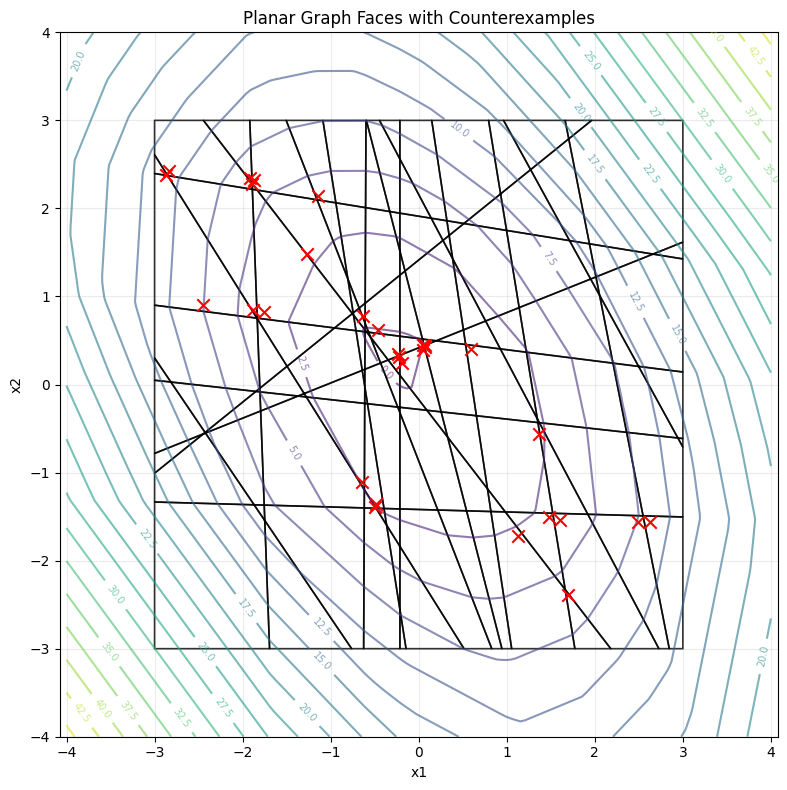

In [27]:
plt.figure(figsize=(8, 8))

for i, polygon_nodes in enumerate(polygons):
    coords = [vertex_dict[v] for v in polygon_nodes]
    if len(coords) < 3:
        continue

    x_vals = [pt[0] for pt in coords] + [coords[0][0]]
    y_vals = [pt[1] for pt in coords] + [coords[0][1]]

    plt.plot(x_vals, y_vals, linewidth=1.2, alpha=0.8, color = 'black')

# if there are counterexamples, plot them as well
if len(counterexamples) > 0:
    ce_x = [pt[0] for pt in counterexamples]
    ce_y = [pt[1] for pt in counterexamples]
    plt.scatter(ce_x, ce_y, color='red', marker='x', s=80, label='Counterexamples', zorder=5)

# also plot the neural network level sets for reference
x1_vals = np.linspace(x1_min - 1, x1_max + 1, 150)
x2_vals = np.linspace(x2_min - 1, x2_max + 1, 150)
X1_grid, X2_grid = np.meshgrid(x1_vals, x2_vals)

grid_points = np.stack([X1_grid.ravel(), X2_grid.ravel()], axis=1)
with torch.no_grad():
    V_values = duffing_nn(torch.tensor(grid_points, dtype=torch.float32)).numpy().reshape(X1_grid.shape)

contours = plt.contour(X1_grid, X2_grid, V_values, levels=20, cmap='viridis', alpha=0.6)
plt.clabel(contours, inline=True, fontsize=7, fmt='%.1f')

plt.title("Planar Graph Faces with Counterexamples")
plt.xlabel("x1")
plt.ylabel("x2")
plt.xlim(x1_min - 1, x1_max + 1)
plt.ylim(x2_min - 1, x2_max + 1)
plt.axis('equal')
plt.grid(True, alpha=0.25)

plt.tight_layout()
plt.show()

Proof of Concept and Workspace

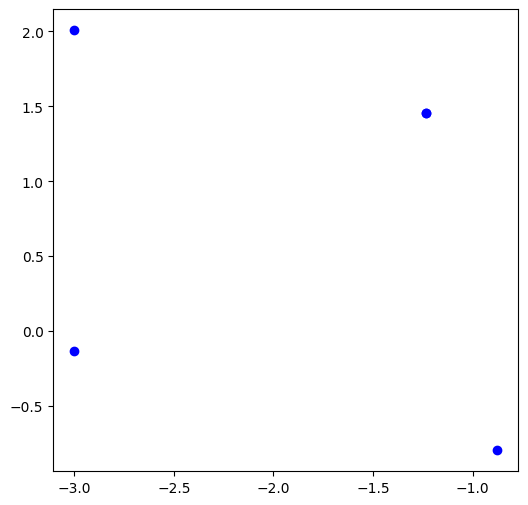

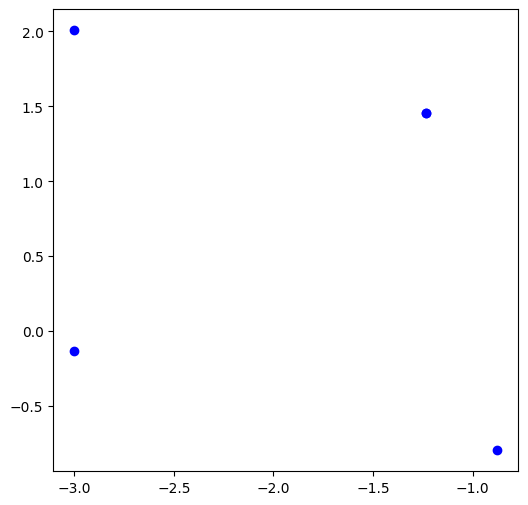

[1.848213890420476, 2.138596914013098, 2.224761241542569, 2.2790494]
points for this edge:  16
points for this edge:  19
points for this edge:  19


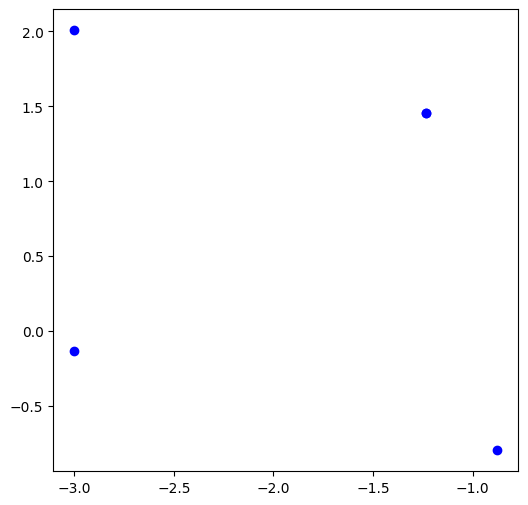

[1.848213890420476, 2.138596914013098, 2.224761241542569, 2.2790494]
points for this edge:  16
points for this edge:  19
points for this edge:  19


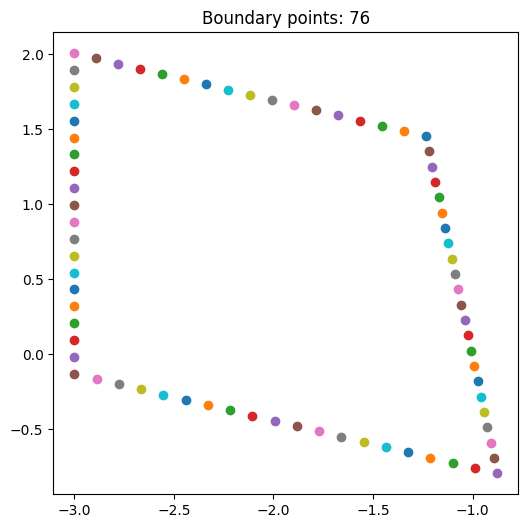

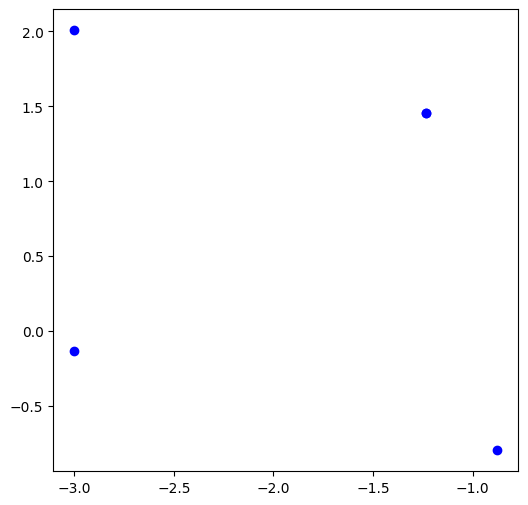

[1.848213890420476, 2.138596914013098, 2.224761241542569, 2.2790494]
points for this edge:  16
points for this edge:  19
points for this edge:  19


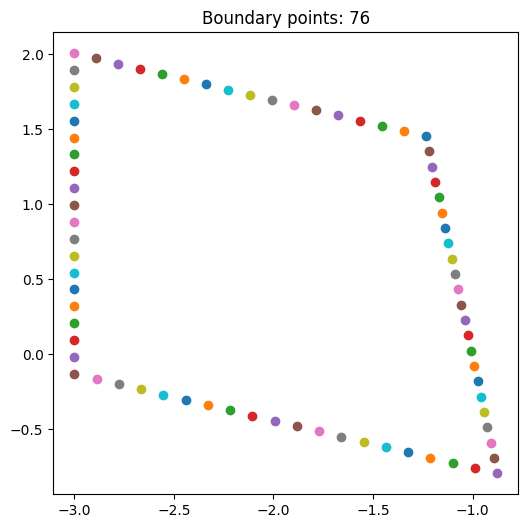

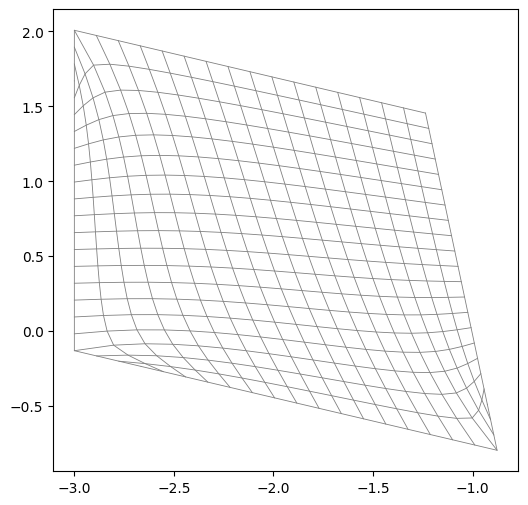

In [160]:
#Need a good method for detecting when the linear combinations of the dynamics are positive or negative

this_polygon = polygons[4]
polygon_vertices = [vertex_dict[v_str] for v_str in this_polygon]
#add the last vertex once more
polygon_vertices.append(polygon_vertices[0])
x_cd = [coord[0] for coord in polygon_vertices]
y_cd = [coord[1] for coord in polygon_vertices]

#plot the polygon
plt.figure(figsize=(6, 6))
plt.scatter(x_cd, y_cd, color = 'blue')
plt.show()

N1 = 20 #number of points on horitonzal edges of unt square
N2 = 20  #number of points on vertical edges of unit square
omega = 4 / (2 + np.sqrt(4 - (np.cos(np.pi / N1) + np.cos(np.pi / N2)**2)))
total_pts = 2 * N1 + 2 * N2 - 4  # these are the total number of discretized points on the boundary of unit square
# we will map these boundary points from the unit square to whatever polygon we are working on
list_of_lengths = []
for i in range(len(polygon_vertices) - 1):
    this_edge = np.array(polygon_vertices[i + 1]) - np.array(polygon_vertices[i])
    this_length = np.linalg.norm(this_edge)
    list_of_lengths.append(this_length)

print(list_of_lengths)
boundary_pt_list = []
poly_perimeter = sum(list_of_lengths)
#now get what percentage of the points should be on each edge
num_pts_left = total_pts
for i in range(len(list_of_lengths) - 1):
    # number of points for this edge (may be zero for very short edges)
    this_edge_num_pts = int((list_of_lengths[i] / poly_perimeter) * total_pts)
    print("points for this edge: ", this_edge_num_pts)
    if this_edge_num_pts <= 0:
        continue
    p0 = np.array(polygon_vertices[i])
    p1 = np.array(polygon_vertices[i+1])
    xs = np.linspace(p0[0], p1[0], this_edge_num_pts, endpoint=False)
    ys = np.linspace(p0[1], p1[1], this_edge_num_pts, endpoint=False)
    for x_new, y_new in zip(xs, ys):
        boundary_pt_list.append((float(x_new), float(y_new)))
    num_pts_left -= this_edge_num_pts

# allocate remaining points to the final edge robustly
last_edge_num_pts = max(0, num_pts_left)
if last_edge_num_pts > 0:
    p0 = np.array(polygon_vertices[-2])   # start of last edge
    p1 = np.array(polygon_vertices[-1])   # end of last edge (duplicate of first)
    xs = np.linspace(p0[0], p1[0], last_edge_num_pts, endpoint=False)
    ys = np.linspace(p0[1], p1[1], last_edge_num_pts, endpoint=False)
    for x_new, y_new in zip(xs, ys):
        boundary_pt_list.append((float(x_new), float(y_new)))

#plot the boundary pts that we found so far
plt.figure(figsize = (6, 6))
for pt in boundary_pt_list:
    plt.scatter(pt[0], pt[1])
plt.title(f'Boundary points: {len(boundary_pt_list)}')
plt.show()

#define the grid of the actual polygon
X = np.zeros((N1, N2), dtype=float)
Y = np.zeros((N1, N2), dtype=float)

#assign the points on the polygon to points on the unit square
#starting from bottom edge, moving counterclockwise
k = 0
# bottom (j=0), i=0..N1-1
for i in range(N1):
    X[i,0], Y[i,0] = boundary_pt_list[k]
    k += 1
# right (i=N1-1), j=1..N1-2
for j in range(1, N1-1):
    X[N1-1,j], Y[N1-1,j] = boundary_pt_list[k]
    k += 1
# top (j=N1-1), i=N1-1..0
for i in range(N1-1, -1, -1):
    X[i,N2-1], Y[i,N1-1] = boundary_pt_list[k]
    k += 1
# left (i=0), j=N1-2..1
for j in range(N2-2, 0, -1):
    X[0,j], Y[0,j] = boundary_pt_list[k]
    k += 1



# initial interior guess by linear interpolation between left/right boundaries
    for j in range(1, N2-1):
        yl = j / (N2-1)
        for i in range(1, N1-1):
            s = i / (N1-1)
            xL, yL = X[0,j], Y[0,j] #right edge
            xR, yR = X[-1,j], Y[-1,j] #left edge
            X[i,j] = (1-s)*xL + s*xR
            Y[i,j] = (1-s)*yL + s*yR

    # SOR method (so basically using the fancy omega from villamizar's notes)
    prev_X = X.copy()
    prev_Y = Y.copy()
    #omega = 1.6
    for it in range(500):
        for i in range(1, N1-1):
            for j in range(1, N2-1):
                x_new = 0.25*(prev_X[i+1,j] + X[i-1,j] + prev_X[i,j+1] + X[i,j-1])
                y_new = 0.25*(prev_Y[i+1,j] + Y[i-1,j] + prev_Y[i,j+1] + Y[i,j-1])
                X[i,j] = omega * x_new + (1 - omega) * prev_X[i, j]
                Y[i,j] = omega * y_new + (1 - omega) * prev_Y[i, j]
        prev_X = X.copy()
        prev_Y = Y.copy()



plt.figure(figsize=(6,6))
# plot grid lines (i-direction)
for i in range(X.shape[0]):
    plt.plot(X[i,:], Y[i,:], color='gray', linewidth=0.6)
# plot grid lines (j-direction)
for j in range(X.shape[1]):
    plt.plot(X[:,j], Y[:,j], color='gray', linewidth=0.6)

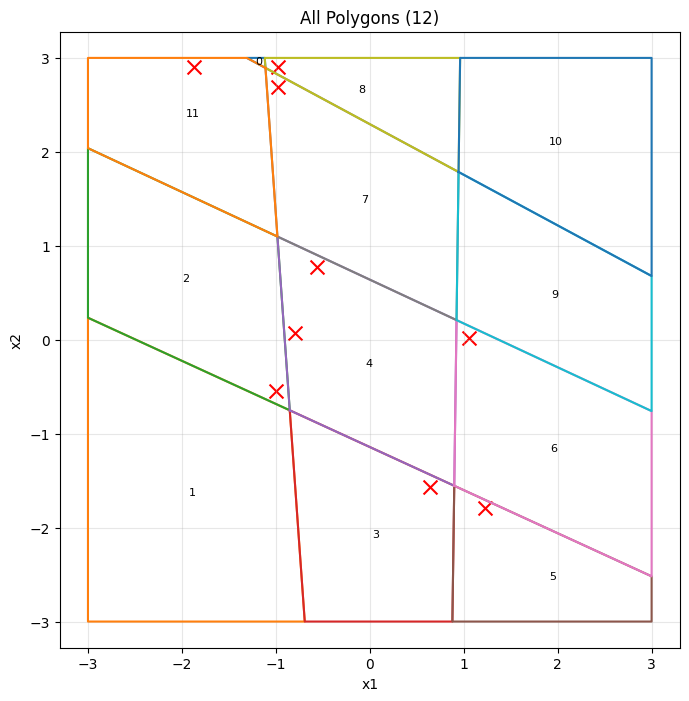

In [15]:
plt.figure(figsize=(8, 8))

for i, polygon_nodes in enumerate(polygons):
    coords = [vertex_dict[v] for v in polygon_nodes]
    if len(coords) < 3:
        continue

    x_vals = [pt[0] for pt in coords] + [coords[0][0]]
    y_vals = [pt[1] for pt in coords] + [coords[0][1]]

    plt.plot(x_vals, y_vals, linewidth=1.5, label=f"P{i}")

    cx = np.mean([pt[0] for pt in coords])
    cy = np.mean([pt[1] for pt in coords])
    plt.text(cx, cy, str(i), fontsize=8, ha='center', va='center')

#also print the counterexample locations
for i in range(len(counterexamples)):
    this_pt = counterexamples[i]
    plt.scatter(this_pt[0], this_pt[1], color='red', marker='x', s=100, label='Counterexample' if i == 0 else "")
plt.title(f"All Polygons ({len(polygons)})")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.grid(True, alpha=0.3)
plt.show()